# EDA

Load in the data:

In [14]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

In [15]:
# data_folder = '../data/train'
# img_files = os.listdir(data_folder)

labels = pd.read_csv('../data/trainLabels.csv')
labels

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
...,...,...
35121,44347_right,0
35122,44348_left,0
35123,44348_right,0
35124,44349_left,0


Checking to make sure train imgs/labels match:

In [3]:
# assert len(img_files) == len(labels)
# for i in labels['image']:
#     assert os.path.exists(os.path.join(data_folder, str(i) + '.jpeg'))

# EDA Images

TODO:
* image resolutions --> DONE (can also find median/quartiles if we want)
* describe pixel values/ranges --> DONE (max values)
* split into train/val/test (70/10/20%) but ensure right/left images do not leak across train/val/test
* normalize/preproc?


Describe image size/resolution and max pixel intensity

In [4]:
# dims = []
# pixels = []

# for count, i in enumerate(img_files):
#     img = Image.open(os.path.join(data_folder, i))
#     dims.append(img.size)
#     pixels.append(img.getextrema())

#     if count % 1000 == 0:
#         print(count, 'of', len(img_files))

# dims = np.array(dims)
# pixels = np.array(pixels)
# np.savez('../data/img_stats.npz', dims=dims, pixels=pixels)

In [16]:
dims = np.load('../data/img_stats.npz')['dims']
pixels = np.load('../data/img_stats.npz')['pixels']

print('dims:')
print('min size:', np.min(dims, axis=0))
print('max size:', np.max(dims, axis=0))
print('mean size:', np.mean(dims, axis=0))
print('std size:', np.std(dims, axis=0))
print()

# pixel_mins = pixels[:, :, 0] --> all 0s
pixel_maxs = pixels[:, :, 1]

print(f'max pixel intensity (RGB):')
print('min:', np.min(pixel_maxs, axis=0))
print('max:', np.max(pixel_maxs, axis=0))
print('mean:', np.mean(pixel_maxs, axis=0))
print('std:', np.std(pixel_maxs, axis=0))

dims:
min size: [400 289]
max size: [5184 3456]
mean size: [3636.65524113 2473.03316632]
std size: [801.81875595 471.46775397]

max pixel intensity (RGB):
min: [12 12 11]
max: [255 255 255]
mean: [245.51340887 225.93053579 184.52767181]
std: [24.02297008 35.57556396 51.26361613]


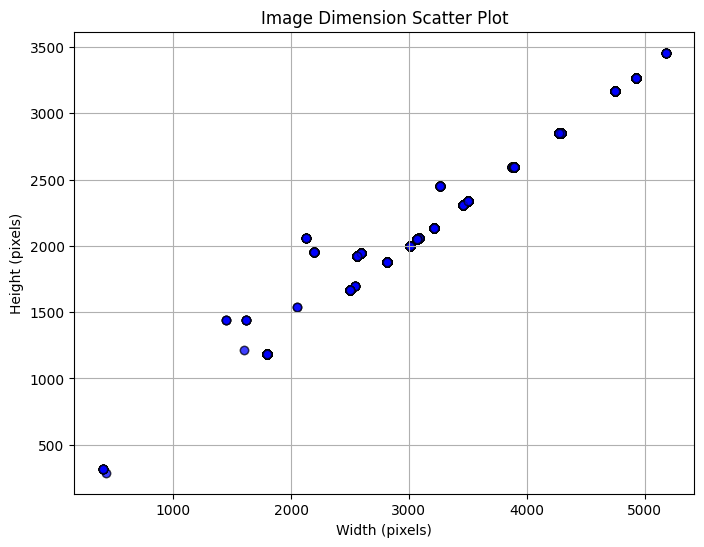

In [17]:
# Convert dims to numpy array
widths, heights = dims[:, 0], dims[:, 1]

# Scatter plot of image dimensions
plt.figure(figsize=(8, 6))
plt.scatter(widths, heights, alpha=0.5, color='blue', edgecolors='black')

plt.title("Image Dimension Scatter Plot")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.grid(True)

plt.show()

# EDA Labels

TODO:
* nan values? --> DONE
* label freqs --> DONE
* label breakdown by right vs left eye? --> DONE

convert level to class label

In [18]:
labels
labels_map = {0: '0-No DR', 1: '1-Mild', 2: '2-Moderate', 3: '3-Severe', 4: '4-Proliferative DR'}  
labels['label'] = labels['level'].map(labels_map)
labels

,image,level,label
0,10_left,0,0-No DR
1,10_right,0,0-No DR
2,13_left,0,0-No DR
3,13_right,0,0-No DR
4,15_left,1,1-Mild
...,...,...,...
35121,44347_right,0,0-No DR
35122,44348_left,0,0-No DR
35123,44348_right,0,0-No DR
35124,44349_left,0,0-No DR


Check if there are any nan values in the dataset:

In [19]:
labels.isna().sum()

image    0
level    0
label    0
dtype: int64

Analyze the label frequencies:

In [20]:
# label frequencies
print(labels['label'].value_counts().sort_index())
print()
print(labels['label'].value_counts(normalize=True).sort_index())

label
0-No DR               25810
1-Mild                 2443
2-Moderate             5292
3-Severe                873
4-Proliferative DR      708
Name: count, dtype: int64

label
0-No DR               0.734783
1-Mild                0.069550
2-Moderate            0.150658
3-Severe              0.024853
4-Proliferative DR    0.020156
Name: proportion, dtype: float64


Visualizing the data label breakup:

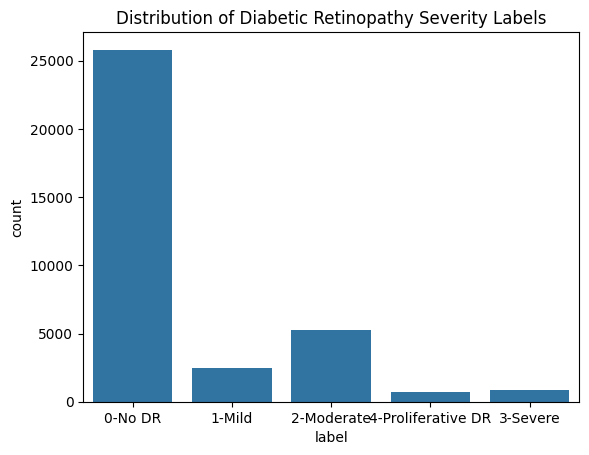

In [21]:
sns.countplot(x='label', data=labels)
plt.title("Distribution of Diabetic Retinopathy Severity Labels")
plt.show()

Determine how similar labels are for left vs right eyes:

In [22]:
leye_labels = labels[labels['image'].str.contains('_left')]
reye_labels = labels[labels['image'].str.contains('_right')]

print('left eye')
print(leye_labels['label'].value_counts().sort_index())
print()
print(leye_labels['label'].value_counts(normalize=True).sort_index())

print()
print()

print('right eye')
print(reye_labels['label'].value_counts().sort_index())
print()
print(reye_labels['label'].value_counts(normalize=True).sort_index())

left eye
label
0-No DR               12871
1-Mild                 1212
2-Moderate             2702
3-Severe                425
4-Proliferative DR      353
Name: count, dtype: int64

label
0-No DR               0.732847
1-Mild                0.069009
2-Moderate            0.153846
3-Severe              0.024199
4-Proliferative DR    0.020099
Name: proportion, dtype: float64


right eye
label
0-No DR               12939
1-Mild                 1231
2-Moderate             2590
3-Severe                448
4-Proliferative DR      355
Name: count, dtype: int64

label
0-No DR               0.736719
1-Mild                0.070091
2-Moderate            0.147469
3-Severe              0.025508
4-Proliferative DR    0.020213
Name: proportion, dtype: float64


Determine how similar labels are for the left/right eye of the same patient:

In [23]:
import numpy as np

pts = labels['image'].str.split('_').str[0].unique()

diff = []
for id in pts:
    leye = labels[labels['image'] == id+'_left']['level'].values
    reye = labels[labels['image'] == id+'_right']['level'].values
    if not leye == reye:
        diff.append(np.abs(leye - reye))

print('number of patients:', len(pts))
print('number of patients with different eye labels:', len(diff))
print('min diff:', np.min(diff))
print('max diff:', np.max(diff))
print('mean diff:', np.mean(diff))
print('median diff:', np.median(diff))

number of patients: 17563
number of patients with different eye labels: 2240
min diff: 1
max diff: 4
mean diff: 1.3607142857142858
median diff: 1.0


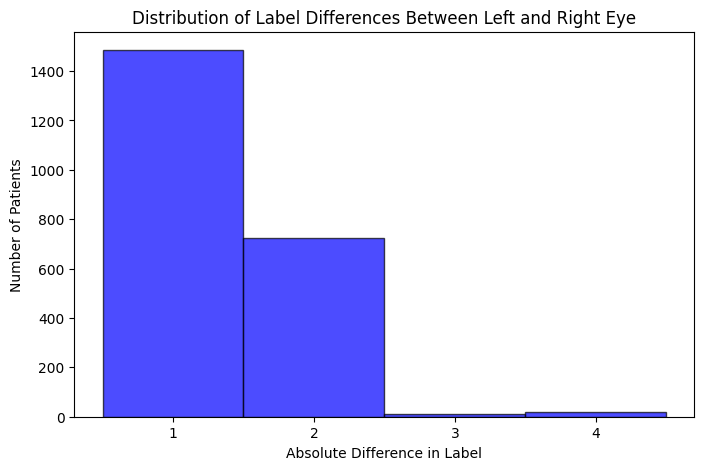

In [26]:
# Assuming diff is a NumPy array or list of scalar values
diff = np.array(diff)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(diff, bins=np.arange(0.5, 5.5, 1),  # Ensure bins are centered on 1,2,3,4
         color='blue', edgecolor='black', alpha=0.7)

plt.title("Distribution of Label Differences Between Left and Right Eye")
plt.xlabel("Absolute Difference in Label")
plt.ylabel("Number of Patients")
plt.xticks([1, 2, 3, 4])  # Ensure x-axis labels are only 1-4

plt.show()